In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# GoodReads Poetry dataset

The full dataset (including other genres) is available at: https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home. We focus here on the _Poetry_ dataset for tractability, as it is the one with the least number of books and reviews.

The files in the `./data/goodreads/` directory are:

- `goodreads_books_poetry.json` : contains information about the books (i.e. nodes)
- `reviews.json` : contains reviews of books by users, with the associated timestamp and ratings

Note that the number of reviews is significantly lower than the number of interactions; indeed, "interacting" on goodreads can be "shelving", posting a review, a rating, etc.

In [8]:
import ujson as json
import math
from sklearn.feature_extraction.text import TfidfVectorizer

from lib.Stream import BipartiteStream
from lib.StreamProperties import *
from lib.TimeNode import TimeNode, TimeNodeSet
from datetime import datetime
from lib.Utils import Utils
from lib.patterns import *

import nltk
from nltk.corpus import words

# nltk.download("punkt")
nltk.download("words")
word_corpus = set(words.words())

DELTA = 36000

[nltk_data] Downloading package words to /home/tiphaine/nltk_data...
[nltk_data]   Package words is already up-to-date!


We isolate relevant words by TF-IDF (Term Frequency - Inverse Document Frequency) score. For a term i in a document d within corpus D, the the TF-IDF is:
$$
    TFIDF_D(i,d) = tf_{i,d} \cdot \log\left(\frac{|D|}{|\{d \in D : i\in d\}|}\right)
$$

In [9]:
def tf_idf(term, document, corpus):
    # TF
    count = 0
    for i in document:
        if i == term:
            count += 1
    frequency = count / len(document)
    # IDF
    df = 0
    for d in corpus:
        if term in set(d):
            df += 1
    return frequency * math.log10(len(corpus) / df)

Create the template of the JSON file that will hold our data. We will consider that the _left_ side refers to books whereas the _right_ side refers to users.

In [10]:
data_stream = {
"settings": {
    "bipartite": 1,
    "weighted": 0,
    "directed": 0,
    "attributed": 1
},
"T": {
    "alpha": 0,
    "omega": 10
},
"V": {
    "left": [],
    "right": []
},
"W": {},
"E": [],
"I": {
        "left": [],
        "right": []
     }
}

## Prepare books information

In [12]:
books_file = open("data/goodreads/goodreads_books_poetry.json")
books = {}
has_reviews = 0

for (i, line) in enumerate(books_file):
    data = json.loads(line)
    # We add "B-" prefixing each attribute to avoid language duplicates between books and users
    book_attributes = [ "B-" + x.strip() for x in map(str.lower, data["description"].split(" ")) if x.strip() in word_corpus ]
    books["B-"+ data["book_id"]] = book_attributes
    # data_stream["I"]["left"] = data_stream["I"]["left"] + book_attributes

## Prepare reviews information

We decide to assign the review text as attributes of the users, and the ndo a matching between the reviews and the book descriptions.

In [13]:
reviews_file = open("data/goodreads/goodreads_reviews_poetry.json")
reviews = []
users_ids = set()
books_ids = set()
labels_users = []
labels_books = []
ratings = {} # sparse matrix ?
links = []
min_date_added = None

for (i,line) in enumerate(reviews_file):
    
    data = json.loads(line)
    
    # Transform date to timestamp
    date_added = datetime.strptime(data["date_added"], "%a %b %d %H:%M:%S %z %Y")
    date_added = date_added.timestamp()
    
    if min_date_added is None or date_added < min_date_added:
        min_date_added = date_added
    
    users_ids.add("U-" + data["user_id"])
    books_ids.add("B-" + data["book_id"])
    reviews.append(data["review_text"])
    
    u = "U-" + data["user_id"]
    v = "B-" + data["book_id"]

    b = date_added - DELTA
    e = date_added + DELTA
    
    # Pick first 5 words of review and description for each node -- FOR TESTS ONLY --
    # map to lowercase
    label_u = [ "U-" + x.strip() for x in map(str.lower, set(data["review_text"].split(" "))) if x.strip() in word_corpus ]
    label_v = list(set(books[v]))
    labels_users.extend(label_u)
    labels_books.extend(label_v)
    
    link = {"b": b, "e": e, "u": v, "v": u, "label": { "left": label_v, "right": label_u } }
    links.append(link)

for i in range(0, len(links)):
    links[i]["b"] -= min_date_added
    links[i]["e"] -= min_date_added

data_stream["T"] = {"alpha": 0, "omega": 10 }
data_stream["V"] = {"left": list(books_ids), "right": list(users_ids)}
data_stream["I"] = {"left": list(set(labels_books)), "right": list(set(labels_users))}
data_stream["E"] = links

In [14]:
len(data_stream["V"]["left"]), len(data_stream["V"]["right"]), len(data_stream["I"]["left"]), len(data_stream["I"]["right"]), len(data_stream["E"])

(36412, 47400, 23401, 35303, 154555)

In [15]:
from lib.Utils import *
import re
I_l = data_stream["I"]["left"]
I_r = data_stream["I"]["right"]
print(len(I_l), len(I_r))
print(len(I_r + I_l))

rem = re.compile("\w") # Match only letters and numbers
ratio_alphanum = lambda x: len(re.findall(rem, x[2:])) / max(len(x[2:]), 1)
ratio_list = [ ratio_alphanum(s) for s in I_l + I_r if ratio_alphanum(s) > 0.95 ]
len(ratio_list)

23401 35303
58704


58704

In [51]:
ccdf_vals = Utils.ccdf(ratio_list)

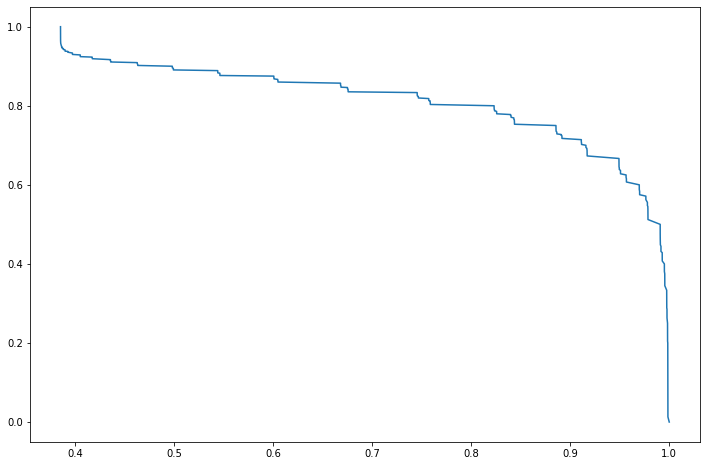

1190882


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(ccdf_vals[1], ccdf_vals[0])
plt.show()
print(len(ratio_list))
ratio_filtered = [x for x in ratio_list if x > 0.95]
ratio_filtered[:10]


Core ideas on edges : assortativity (above $k$), shortest paths involving edge (filter on number ?)

In [16]:
json.dump(data_stream, open("data/goodreads_poetry.json", "w"))

## Create stream

Read from the file that was prepared in the first section of this notebook.

In [17]:
# s = Stream(lang=set(labels_users + labels_books), _fp=open("results.txt", "w+"))
s = BipartiteStream()
s.readStream("data/goodreads_poetry.json")

In [18]:
core_property = StreamStarSat(s, threshold=5)
s.setCoreProperty(core_property)

In [19]:
type(s.core_property) is StreamStarSat, s.core_property.threshold

(True, 5)

In [21]:
len(s.E), len(s.I["left"]), len(s.I["right"])

(154555, 23401, 35303)

In [22]:
s.E[0]

{'b': 189125944.0,
 'e': 189197944.0,
 'u': 'B-402128',
 'v': 'U-3ca7375dba942a760e53b726c472a7dd',
 'label': {'left': ['B-legendary',
   'B-they',
   'B-as',
   'B-the',
   'B-delighted',
   'B-in',
   'B-his',
   'B-later',
   'B-first',
   'B-around',
   'B-for',
   'B-were',
   'B-and',
   'B-since',
   'B-composed',
   'B-posing',
   'B-originally',
   'B-possum',
   'B-cat',
   'B-musical',
   'B-old',
   'B-have',
   'B-inspired',
   'B-playful',
   'B-ever',
   'B-world',
   'B-with'],
  'right': ['U-creative',
   'U-used',
   'U-with',
   'U-all',
   'U-whereas',
   'U-younger',
   'U-really',
   'U-fun',
   'U-idea',
   'U-this',
   'U-have',
   'U-came',
   'U-familiar',
   'U-musical',
   'U-a',
   'U-no',
   'U-looking',
   'U-sofa',
   'U-grew',
   'U-one',
   'U-anyone',
   'U-some',
   'U-who',
   'U-trouble',
   'U-as',
   'U-up',
   'U-found',
   'U-the',
   'U-them',
   'U-read',
   'U-the',
   'U-book',
   'U-tell',
   'U-do',
   'U-remember',
   'U-three',
   'U-we

In [23]:
import time
start = time.perf_counter()
#X1 = [TimeNode(x["u"], x["b"], x["e"]) for x in s.E ]
#X2 = [TimeNode(x["v"], x["b"], x["e"]) for x in s.E ]
#X = X1 + X2
#X = TimeNodeSet(elements=X)
#s.W = X
res_int = interior(s)
end = time.perf_counter()
print(end - start)

7.9423313370207325


In [68]:
bipatterns(s)

KeyboardInterrupt: 

In [62]:
s.label(TimeNode("B-402128", 196398437.0,196403331.0))

{'B-1939.',
 'B-and',
 'B-around',
 'B-as',
 'B-cat',
 'B-cats.',
 'B-composed',
 'B-delighted',
 'B-eliot',
 "B-eliot's",
 'B-ever',
 'B-first',
 'B-for',
 'B-godchildren,',
 'B-have',
 'B-himself,',
 'B-his',
 'B-in',
 'B-inspired',
 'B-later',
 'B-legendary',
 'B-lovers',
 'B-musical',
 'B-old',
 'B-originally',
 'B-playful',
 'B-poems',
 'B-posing',
 'B-possum',
 'B-published',
 'B-readers',
 'B-s.',
 'B-since',
 'B-t.',
 'B-the',
 'B-they',
 'B-were',
 'B-with',
 'B-world'}

In [37]:
list(s.V)[0:10]

['fe488adb521619bebb35028a61c5cdde',
 'b41fd369eec21e02a9ad56c8608c3823',
 'edb780cdc27b4fe316fbc72c1588ed09',
 '5153111a7b8025c21253deb34c995e02',
 'c12609bcc482938019be17a15ee4d171',
 '5290036',
 'bbb6abbad493a606c959f445f2cc793f',
 '38b42c397fd456385bc79356a0feacee',
 '848098',
 '5956803']

In [10]:
vectorizer = TfidfVectorizer(use_idf=True)
res = vectorizer.fit_transform(reviews)

Total number of concepts (i.e. distinct words in reviews)

In [11]:
n_users, n_books, n_reviews, n_concepts = len(users), len(books), len(reviews), len(vectorizer.get_feature_names())
print(f"{n_users} users, {n_books} books, {n_reviews} reviews, {n_concepts} concepts (i.e. distinct words in reviews)")

47400 users, 36412 books, 154555 reviews, 403416 concepts (i.e. distinct words in reviews)


In [12]:
tfidf_values = [round(i, 3) for i in res.data]
len(tfidf_values)

9292775

In [13]:
ccdf_values = Utils.ccdf(tfidf_values)
import numpy as np
np.mean(tfidf_values)

0.09749984294250118

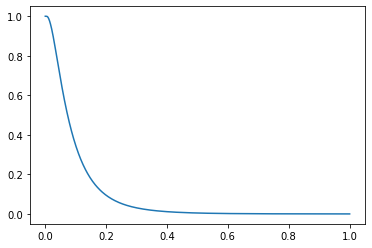

In [14]:
plt.plot(ccdf_values[0], ccdf_values[1])

In [15]:
def parse_review(text, threshold=0.0):
    print(vectorizer.get_feature_names()[143450:143550])

import pandas as pd

In [59]:
# vectorizer.get_feature_names()[i], for a given i, will output the associated word
# However, it's slow, and we don't really need it so far, so we keep to integers indices
filter_tfidf_scores = lambda r: [ (i, v) for i, v in enumerate(r) if v > 0.1 ]
filter_tfidf_scores = lambda r: r.eliminate_zeros() # [ (i, v) for i, v in enumerate(r) if v > 0.1 ]

words_per_review = []
for i, r in enumerate(res):
    if i % 10000 == 0:
        print(i)
    
    tfidf_scores = r.eliminate_zeros().toarray()[0]
    result = filter_tfidf_scores(tfidf_scores)
    words_per_review.append(len(result))

0


AttributeError: 'NoneType' object has no attribute 'toarray'